In [30]:
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import col, year, to_date, greatest, count, max
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder,OneHotEncoderModel, StringIndexer, VectorAssembler

In [2]:
spark = SparkSession.builder.appName("Stock_Analysis").config(
    "spark.ui.port", "0").config(
        "spark.sql.catalogImplementation=hive").config(
        "spark.sql.warehouse.dir",
        "hdfs://nameservice1/user/itv003722/warehouse").config(
            "spark.serializer",
    "org.apache.spark.serializer.KryoSerializer").enableHiveSupport().getOrCreate()
spark.sparkContext.setLogLevel('OFF')

In [3]:
SA = spark.table('bdsh_project.stock_detail')

In [4]:
SA.createOrReplaceTempView('SA')

In [5]:
SA.show()

+----+-----+------+--------------------+-----------+-----------+--------------------+-----+-----+-----+-----+--------+
|year|month|symbol|         companyname|      state|     sector|        sub_industry| open|close|  low| high|  volume|
+----+-----+------+--------------------+-----------+-----------+--------------------+-----+-----+-----+-----+--------+
|2010|    1|     A|Agilent Technolog...| California|Health Care|Health Care Equip...|20.69|20.05|19.97|20.87| 5923000|
|2010|    1|     A|Agilent Technolog...| California|Health Care|Health Care Equip...|20.84|20.52|20.38|21.01| 4937100|
|2010|    1|     A|Agilent Technolog...| California|Health Care|Health Care Equip...|20.89|20.87|20.55|20.95| 4362100|
|2010|    1|     A|Agilent Technolog...| California|Health Care|Health Care Equip...|21.01|20.95|20.73| 21.1| 2696800|
|2010|    1|     A|Agilent Technolog...| California|Health Care|Health Care Equip...|21.04|21.07|20.91|21.21| 3608500|
|2010|    1|     A|Agilent Technolog...| Califor

In [6]:
SA.printSchema()
SA.count()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- symbol: string (nullable = true)
 |-- companyname: string (nullable = true)
 |-- state: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- sub_industry: string (nullable = true)
 |-- open: double (nullable = true)
 |-- close: double (nullable = true)
 |-- low: double (nullable = true)
 |-- high: double (nullable = true)
 |-- volume: integer (nullable = true)



851259

In [7]:
#To check the Growth of eac company to  Add the column growth
SA=SA.withColumn('growth',((F.col("open")-F.col("close"))/F.col("open"))*100)

In [8]:
SA.createOrReplaceTempView('SA')
SA.show()

+----+-----+------+--------------------+-----------+-----------+--------------------+-----+-----+-----+-----+--------+--------------------+
|year|month|symbol|         companyname|      state|     sector|        sub_industry| open|close|  low| high|  volume|              growth|
+----+-----+------+--------------------+-----------+-----------+--------------------+-----+-----+-----+-----+--------+--------------------+
|2010|    1|     A|Agilent Technolog...| California|Health Care|Health Care Equip...|20.69|20.05|19.97|20.87| 5923000|  3.0932817786370252|
|2010|    1|     A|Agilent Technolog...| California|Health Care|Health Care Equip...|20.84|20.52|20.38|21.01| 4937100|  1.5355086372360858|
|2010|    1|     A|Agilent Technolog...| California|Health Care|Health Care Equip...|20.89|20.87|20.55|20.95| 4362100| 0.09573958831976818|
|2010|    1|     A|Agilent Technolog...| California|Health Care|Health Care Equip...|21.01|20.95|20.73| 21.1| 2696800|   0.285578296049511|
|2010|    1|     A|A

In [9]:
SA.select("growth").show(10)

+-------------------+
|             growth|
+-------------------+
| 3.0932817786370252|
| 1.5355086372360858|
|0.09573958831976818|
|  0.285578296049511|
|-0.1425855513308039|
| 3.8691847075080603|
|-1.4272559852670457|
|-0.6880733944954063|
|-0.3205128205128218|
|0.36596523330282843|
+-------------------+
only showing top 10 rows



In [10]:
SA.count()

851259

In [11]:
dfp=SA.toPandas()

In [12]:
dfp.head(2)

,year,month,symbol,companyname,state,sector,sub_industry,open,close,low,high,volume,growth
0,2010,1,A,Agilent Technologies Inc,California,Health Care,Health Care Equipment,20.69,20.05,19.97,20.87,5923000,3.093282
1,2010,1,A,Agilent Technologies Inc,California,Health Care,Health Care Equipment,20.84,20.52,20.38,21.01,4937100,1.535509


In [13]:
dfp.dtypes

year              int32
month             int32
symbol           object
companyname      object
state            object
sector           object
sub_industry     object
open            float64
close           float64
low             float64
high            float64
volume            int32
growth          float64
dtype: object

In [14]:
cont_var_df=dfp.loc[:,(dfp.dtypes=='float64') | (dfp.dtypes=='int32')]
cat_var_df=dfp.loc[:,(dfp.dtypes=='object')]

In [15]:
# ### Continous Variables
def func_describe(_):
    '''
        Calculates different metrics of Numerical column
    '''
    # Records and missing values
    n_tot = _.shape[0]
    n_count = _.count()
    n_miss = _.isna().sum()
    n_miss_perc = n_miss / n_tot

    # IQR
    q_1 = _.quantile(0.25)
    q_3 = _.quantile(0.75)
    iqr = q_3 - q_1
    lc_iqr = q_1 - 1.5 * iqr
    uc_iqr = q_3 + 1.5 * iqr

    return pd.Series(data=[
        _.dtypes, n_tot, n_count, n_miss, n_miss_perc,
        _.nunique(),
        _.sum(),
        _.mean(),
        _.std(),
        _.var(), iqr, lc_iqr, uc_iqr,
        _.min(),
        _.max(),
        _.quantile(0.01),
        _.quantile(0.05),
        _.quantile(0.1),
        _.quantile(0.25),
        _.quantile(0.5),
        _.quantile(0.75),
        _.quantile(0.90),
        _.quantile(0.95),
        _.quantile(0.99)
    ],
        index=[
        'dtype', 'tot', 'n', 'nmiss', 'miss_perc',
        'cardinality', 'sum', 'mean', 'std', 'var', 'iqr',
        'lc_iqr', 'uc_iqr', 'min', 'max', 'p1', 'p5', 'p10',
        'p25', 'p50', 'p75', 'p90', 'p95', 'p99'
    ])


cont_var_df.apply(func_describe).round(1).T.head(50)



,dtype,tot,n,nmiss,miss_perc,cardinality,sum,mean,std,var,...,max,p1,p5,p10,p25,p50,p75,p90,p95,p99
year,int32,851259,851259,0,0,7,1713627357,2013.05,2.00167,4.00668,...,2016,2010,2010,2010,2011,2013,2015,2016,2016,2016
month,int32,851259,851259,0,0,12,5580322,6.55538,3.42519,11.7319,...,12,1,1,2,4,7,10,11,12,12
open,float64,851259,851259,0,0,36288,5.53266e+07,64.9938,75.2041,5655.65,...,1584.44,7.82,14.36,19.64,31.27,48.46,75.12,113.33,154.65,368.828
close,float64,851259,851259,0,0,36856,5.53422e+07,65.0121,75.2014,5655.25,...,1578.13,7.82,14.37,19.65,31.29,48.48,75.14,113.37,154.67,368.738
low,float64,851259,851259,0,0,36197,5.47672e+07,64.3368,74.4597,5544.24,...,1549.94,7.69,14.17,19.4,30.94,47.97,74.4,112.27,153.04,365.097
high,float64,851259,851259,0,0,36540,5.58766e+07,65.64,75.907,5761.88,...,1600.93,7.94,14.56,19.88,31.62,48.96,75.85,114.38,156.201,372.42
volume,int32,851259,851259,0,0,171073,4609690446400,5.41514e+06,1.24947e+07,1.56118e+14,...,859643400,248700,476400,673500,1.2215e+06,2.4763e+06,5.22255e+06,1.09693e+07,1.8014e+07,4.99251e+07
growth,float64,851259,851259,0,0,574491,-35767.8,-0.0420176,1.47832,2.18544,...,25.5378,-4.06018,-2.29645,-1.63585,-0.794858,-0.0461595,0.702051,1.5729,2.25898,4.00099


In [16]:
# ### Categorical Variables
def func_obj_describe(_):
    '''
        Calculates different metrics of Categorical column
    '''
    # Records and missing values
    n_tot = _.shape[0]
    n_count = _.count()
    n_miss = _.isna().sum()
    n_miss_perc = n_miss / n_tot

    return pd.Series(data=[
        _.dtypes, n_tot, n_count, n_miss, n_miss_perc,
        _.nunique()
    ],
        index=[
        'dtype', 'tot', 'n', 'nmiss', 'miss_perc',
        'cardinality'
    ])


cat_var_df.apply(func_obj_describe).round(1).T.head(50)

,dtype,tot,n,nmiss,miss_perc,cardinality
symbol,object,851259,851259,0,0,501
companyname,object,851259,851259,0,0,501
state,object,851259,851259,0,0,53
sector,object,851259,851259,0,0,11
sub_industry,object,851259,851259,0,0,124


In [17]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [18]:
cont_var_df = cont_var_df.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.quantile(0.99)))

In [19]:
cont_var_df

,year,month,open,close,low,high,volume,growth
0,2010,1,20.69,20.05,19.97,20.87,5923000.0,3.093282
1,2010,1,20.84,20.52,20.38,21.01,4937100.0,1.535509
2,2010,1,20.89,20.87,20.55,20.95,4362100.0,0.095740
3,2010,1,21.01,20.95,20.73,21.10,2696800.0,0.285578
4,2010,1,21.04,21.07,20.91,21.21,3608500.0,-0.142586
...,...,...,...,...,...,...,...,...
851254,2016,12,53.33,53.12,52.73,53.41,2754600.0,0.393775
851255,2016,12,53.47,53.62,53.40,53.78,1046700.0,-0.280531
851256,2016,12,53.64,53.53,53.27,53.74,1701200.0,0.205071
851257,2016,12,53.76,53.44,53.35,53.85,1241900.0,0.595238


In [21]:
def count_charts(x):
    sns.countplot(x)
    plt.show()

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/itv003722/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


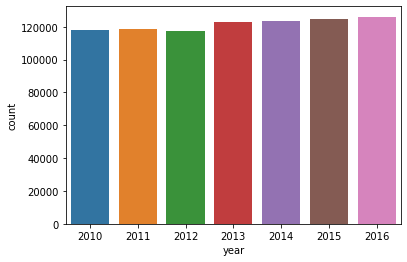

/home/itv003722/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


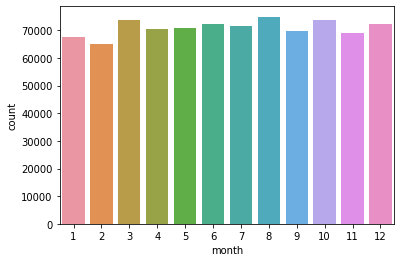

/home/itv003722/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


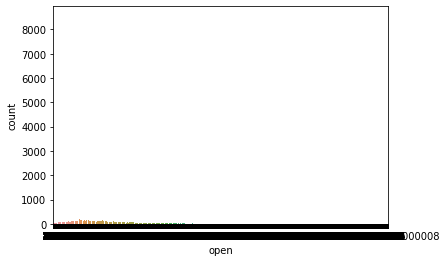

/home/itv003722/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


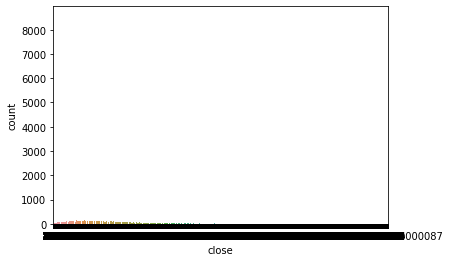

/home/itv003722/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


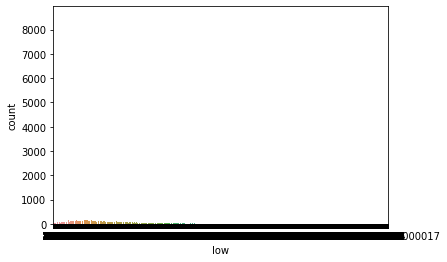

/home/itv003722/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


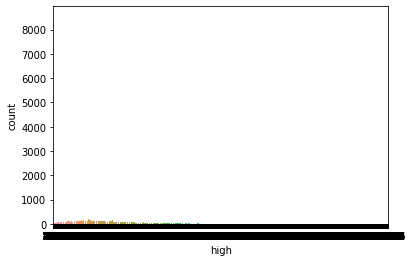

/home/itv003722/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


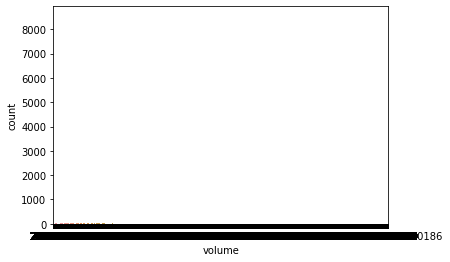

/home/itv003722/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [ ]:
cont_var_df.apply(count_charts)

In [20]:
# get the useful categorical variables


# for c_feature in categorical_features
for c_feature in ['companyname', 'state','sector','sub_industry']:
    cat_var_df[c_feature] = cat_var_df[c_feature].astype('category')
    cat_var_df = create_dummies(cat_var_df, c_feature)
    
# see the data in the output
#cat_var_df

/opt/anaconda3/envs/beakerx/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
cat_var_df

,symbol,companyname_AES Corp,companyname_AFLAC Inc,companyname_AMETEK Inc,companyname_AT&T Inc,companyname_AbbVie,companyname_Abbott Laboratories,companyname_Accenture plc,companyname_Activision Blizzard,companyname_Acuity Brands Inc,...,sub_industry_Systems Software,sub_industry_Technology Hardware; Storage & Peripherals,sub_industry_Technology; Hardware; Software and Supplies,sub_industry_Telecommunications Equipment,sub_industry_Thrifts & Mortgage Finance,sub_industry_Tires & Rubber,sub_industry_Tobacco,sub_industry_Trading Companies & Distributors,sub_industry_Trucking,sub_industry_Water Utilities
0,A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851254,ZTS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
851255,ZTS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
851256,ZTS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
851257,ZTS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df_new = pd.concat([cont_var_df, cat_var_df], axis = 1)

In [23]:
df_new.head(5)

,year,month,open,close,low,high,volume,growth,symbol,companyname_AES Corp,...,sub_industry_Systems Software,sub_industry_Technology Hardware; Storage & Peripherals,sub_industry_Technology; Hardware; Software and Supplies,sub_industry_Telecommunications Equipment,sub_industry_Thrifts & Mortgage Finance,sub_industry_Tires & Rubber,sub_industry_Tobacco,sub_industry_Trading Companies & Distributors,sub_industry_Trucking,sub_industry_Water Utilities
0,2010,1,20.69,20.05,19.97,20.87,5923000.0,3.093282,A,0,...,0,0,0,0,0,0,0,0,0,0
1,2010,1,20.84,20.52,20.38,21.01,4937100.0,1.535509,A,0,...,0,0,0,0,0,0,0,0,0,0
2,2010,1,20.89,20.87,20.55,20.95,4362100.0,0.095740,A,0,...,0,0,0,0,0,0,0,0,0,0
3,2010,1,21.01,20.95,20.73,21.10,2696800.0,0.285578,A,0,...,0,0,0,0,0,0,0,0,0,0
4,2010,1,21.04,21.07,20.91,21.21,3608500.0,-0.142586,A,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/itv003722/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


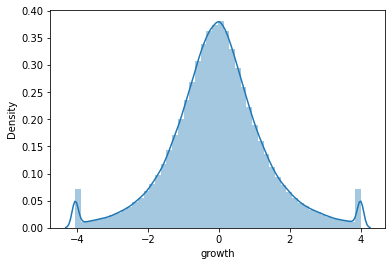

In [31]:
sns.distplot(df_new.growth)
plt.show()

<AxesSubplot:>

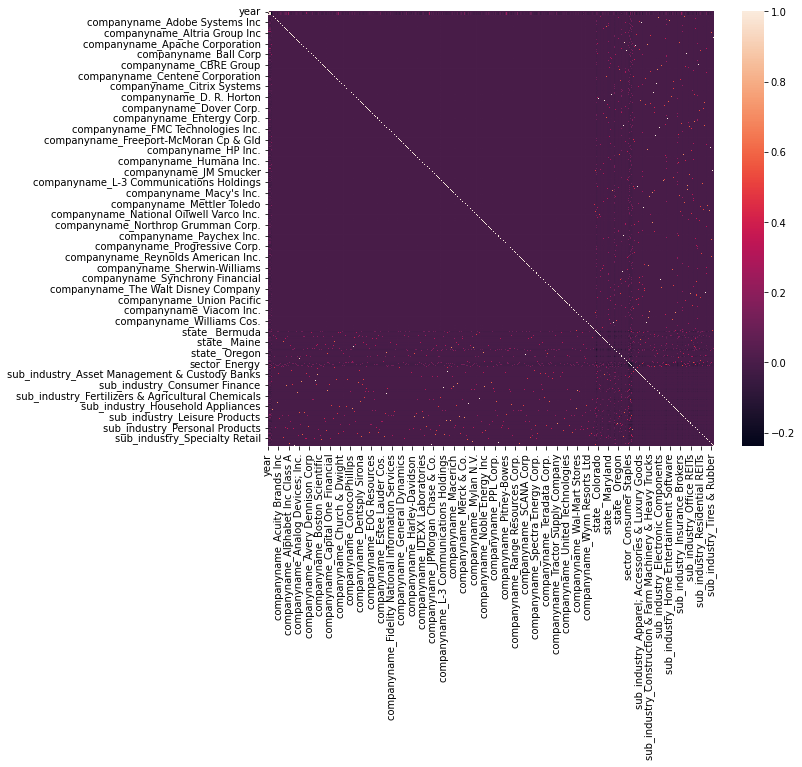

In [32]:
# visualize correlation matrix in Seaborn using a heatmap
plt.figure(figsize = (10, 8))
sns.heatmap(df_new.corr())

In [ ]:
# Linearity: correlation matrix (ranges from 1 to -1)
corrm = df_new.corr()
corrm.to_excel('corrm.xlsx')
corrm